In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from wave_prop_module import Wave2d
from torch import optim
from unet import UNet
from loss_fns import *

In [2]:
def propagation(numPx, sizePx=[6*1e-6, 6*1e-6], wl=550*1e-9):

    sizeSensorX = numPx[0]*sizePx[0] # sensor size along x-axis
    sizeSensorY = numPx[1]*sizePx[1] # sensor size along y-axis

    # Sampling plane 2x for linearization
    Sx = sizeSensorX
    Sy = sizeSensorY

    # max freq to prevent aliasing by the transfer function
    delU = 1/Sx
    delV = 1/Sy

    freqRows = torch.linspace(-1/(2*sizePx[0]), 1/(2*sizePx[0]), round(1/(sizePx[0]*delU))) ## -maxFreq/2, +maxFreq/2
    freqCols = torch.linspace(-1/(2*sizePx[1]), 1/(2*sizePx[1]), round(1/(sizePx[1]*delV)))

    u, v = torch.meshgrid(freqRows, freqCols)
    k = wl**(-2) - u**2 - v**2

    return torch.sqrt(k)

In [10]:
model = UNet(num_input_channels=1, num_output_channels=1) # postprocessor

# complete model
device = torch.device('cuda:0')

# incident wave
X, Y = np.meshgrid(np.linspace(-1, 1, 1024), np.linspace(-1, 1, 1360))

A = torch.tensor([X.T.ravel(), Y.T.ravel(), X.T.ravel()*Y.T.ravel(), X.T.ravel()*X.T.ravel(), Y.T.ravel()*Y.T.ravel(), np.ones_like(X.T.ravel()), 
              (X.T.ravel())**3, (Y.T.ravel())**3, X.T.ravel()*(Y.T.ravel())**2, Y.T.ravel()*(X.T.ravel())**2], dtype=torch.float32).T


# coeffs = torch.rand(10, 1, requires_grad=True)
# coeffs = torch.FloatTensor(10, 1).uniform_(-1, 1)
coeffs = torch.tensor([[ -13.53],
        [-113.3250],
        [ -12.7425],
        [   4.4154],
        [   6.2158],
        [ -119.261],
        [   2.3329],
        [  1.3617],
        [   1.5364],
        [  3.5796]])
coeffs.requires_grad=True

# obj_amp = torch.rand(1024, 1360, requires_grad=True)
obj_phase = torch.rand(1024, 1360, requires_grad=True)
obj_amp = torch.rand(1024, 1360, requires_grad=True)

phase_img = np.load('phase_0.npy')
abs_img = np.load('abs_0.npy')

target_phase = torch.tensor(phase_img).T
target_abs = torch.tensor(abs_img).T

cons = torch.tensor(3.2, requires_grad=True)
# dist = torch.tensor(145.003) # mm 


optimizer = optim.Adam([
    {'params': obj_phase, 'lr': 1e-1},
    {'params': obj_amp, 'lr': 1e-1},
    {'params': coeffs, 'lr': 1e-1},
    {'params': cons, 'lr': 1e-2},
    # {'params': dist, 'lr': 1e-2}
    ],
    lr=0.01, betas=(0.9, 0.999)
    )
optimizer_proc = optim.Adam([
    {'params': model.parameters(), 'lr': 2e-2}],
    lr=0.01, betas=(0.9, 0.999)
    )

wave_obj = Wave2d(
        numPx = list(obj_phase.shape), 
        sizePx = [6*1e-3, 6*1e-3], 
        wl = 550*1e-6
        )

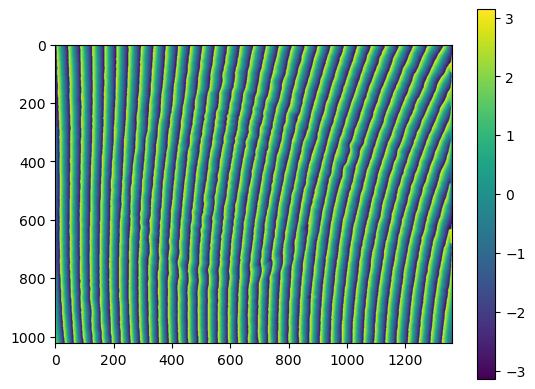

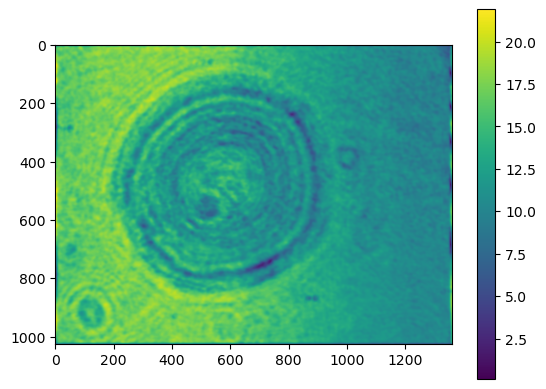

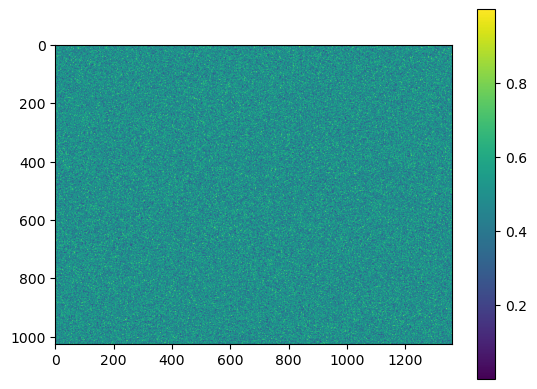

In [11]:
plt.imshow(target_phase.T)
plt.colorbar()
plt.show()

plt.imshow(target_abs.T)
plt.colorbar()
plt.show()

plt.imshow(obj_phase.detach())
plt.colorbar()
plt.show()

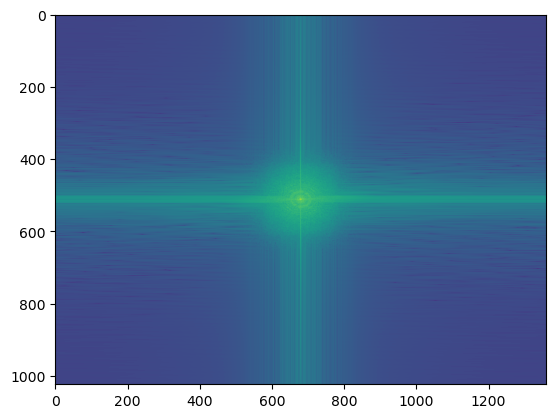

In [12]:
plt.imshow(np.fft.fftshift(np.log10(torch.abs(torch.fft.fft2(target_abs.T)))))

0 0.4317058161317534


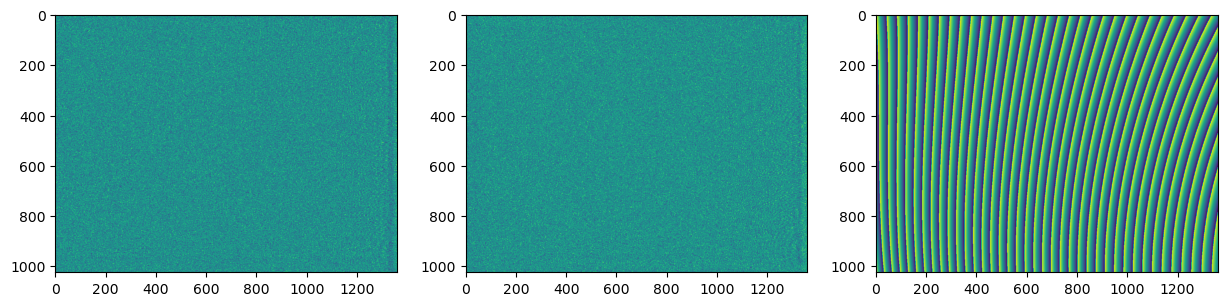

1 0.3297229104033251
2 0.27439348233466093
3 0.25255269750142595
4 0.24115466235303942
5 0.22834710155497084
6 0.21347547621637802
7 0.19864788076664514
8 0.18562908238306652
9 0.175109572286811
10 0.16659488177368015
11 0.15915679695575605
12 0.1522034742496357
13 0.14561135957095664
14 0.13954802528102478
15 0.13413811384343927
16 0.1293379918538075
17 0.12504732633633514
18 0.1211490717912909
19 0.11765398533267497
20 0.11441197645840102
21 0.11147792021358335
22 0.10877802310077768
23 0.10625774744284433
24 0.1038711905411021
25 0.10166183935043055
26 0.09955902923696103
27 0.09763338818259717
28 0.0958863770846532
29 0.09424379152873175
30 0.09277658468600769
31 0.09140836496094344
32 0.0902090700736905
33 0.08909616244431241
34 0.08807413584311273
35 0.08717309312474544
36 0.08629412062447668
37 0.08553215652196998
38 0.08480147139535743
39 0.08418072029155635
40 0.08355881304384521
41 0.08302705184322906
42 0.08250110103776245
43 0.08204030408825545
44 0.08159143027478558
45 0.0

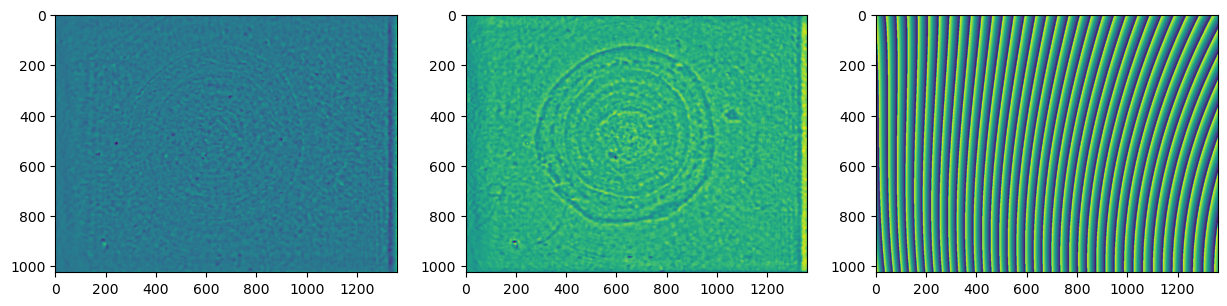

51 0.07932877019965404
52 0.07905764804037073
53 0.07883999498505573
54 0.07860066233552183
55 0.07841385963853309
56 0.0781948034941937
57 0.07800427533650936
58 0.07783839423357095
59 0.07765097801072836
60 0.0774845304147063
61 0.07733410226575166
62 0.07715235860792041
63 0.07705116538629986
64 0.07687856851908297
65 0.07677254264578634
66 0.07661368025725526
67 0.07650286380461171
68 0.07637921445968132
69 0.07624831977449646
70 0.0761210269873884
71 0.07601795297110904
72 0.07589473870921305
73 0.07581322602613619
74 0.07568504830541978
75 0.07560306799753098
76 0.07548801091583236
77 0.07539461543319871
78 0.07529709551448485
79 0.07521054116651686
80 0.07510496837128444
81 0.07503303793401803
82 0.07492107736672995
83 0.0748438040850466
84 0.0747422370340359
85 0.07465400540313999
86 0.07457310405207279
87 0.07448242903880248
88 0.07440668034504946
89 0.0743013119325951
90 0.07425775820443058
91 0.0741328288663731
92 0.07408746524930113
93 0.0739945283700492
94 0.07391695536508

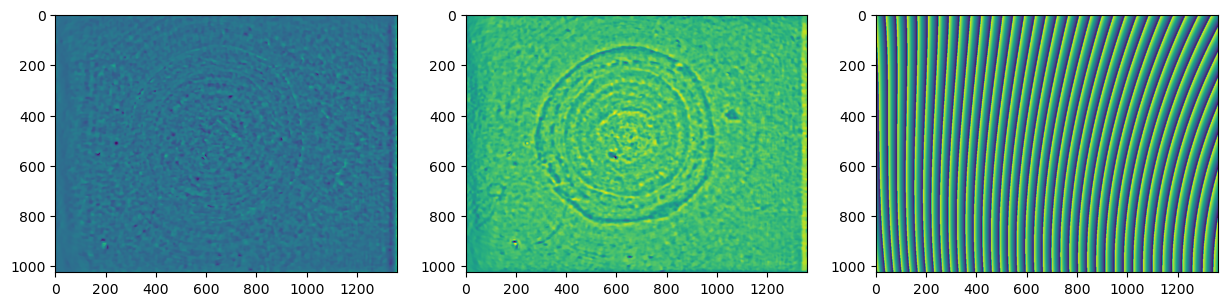

101 0.07336553810119874
102 0.07331772008531633
103 0.07320833168149912
104 0.07316975257844818
105 0.07304903469637383
106 0.0730398234662875
107 0.07293445686710442
108 0.07287928156397361
109 0.07279489765625362
110 0.07275986626640826
111 0.07265726307465636
112 0.0726035808291755
113 0.07253267093934423
114 0.07247259305455767
115 0.07239806258009138
116 0.07232615392828158
117 0.07228719642897702
118 0.07219297302353901
119 0.07214675309635786
120 0.07206300546664694
121 0.07200162624672565
122 0.07193961708243667
123 0.07187480959147179
124 0.07181358463295519
125 0.07175632169824916
126 0.07167595362624023
127 0.07164589733812551
128 0.07153575474956378
129 0.07150809235668712
130 0.0714080650194756
131 0.07137589707876066
132 0.07128433690480243
133 0.07125943519944564
134 0.07117476929342301
135 0.07112222068277091
136 0.07105524517488136
137 0.07100282500553534
138 0.07093410587408887
139 0.07088154010995959
140 0.07081243151291675
141 0.07076755954981542
142 0.0707066307079

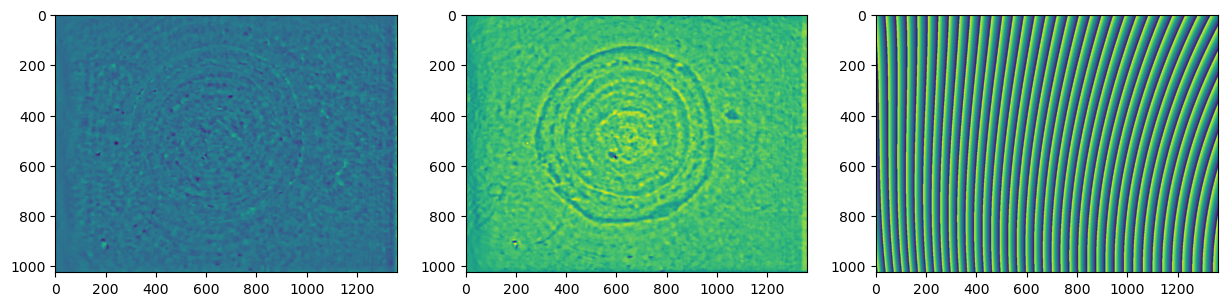

151 0.07019807844440519
152 0.07014148792917832
153 0.0700619649655208
154 0.07002938828439922
155 0.06996481093152443
156 0.06991986722546054
157 0.06985430223326591
158 0.06981436063574922
159 0.06975188358517878
160 0.06969995457670894
161 0.06965942092135578
162 0.06957449080710855
163 0.06953684198489699
164 0.06946829186541689
165 0.06943664438136113
166 0.06939845943778848
167 0.06931316987527868
168 0.06928902650541803
169 0.0692239731152186
170 0.06915530212052182
171 0.06912598266891556
172 0.06904448905205875
173 0.06902544282813365
174 0.06894836730059757
175 0.06891655064059785
176 0.06884899714197118
177 0.06880696520599189
178 0.0687590983935938
179 0.06870876320989328
180 0.06863547364957943
181 0.06861268298420045
182 0.06854591938270707
183 0.06850321327635601
184 0.06846868147037685
185 0.06838811746163644
186 0.06837913551463067
187 0.06831612068863627
188 0.06826428082423638
189 0.06823866525825142
190 0.06816760305136622
191 0.06814530614875763
192 0.0680815104451

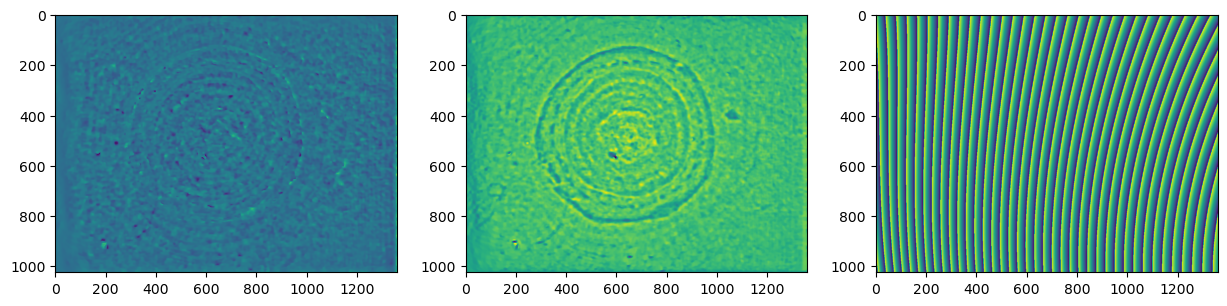

201 0.06768638313897858
202 0.06765825343104795
203 0.06760118977343316
204 0.06755631281511237
205 0.06751851740186332
206 0.0674613046350536
207 0.06740398526218028
208 0.0673760940660181
209 0.06730628333307336
210 0.06728440690956299
211 0.06722936008898314
212 0.0671868589267795
213 0.06713923171999556
214 0.06709923560879039
215 0.06706282461662418
216 0.06699890202060763
217 0.06696611252083057
218 0.06691858760296229
219 0.06689470624588964
220 0.06685293634185449
221 0.06681763249755732
222 0.06679070640924212
223 0.06673429113975518
224 0.06670965801484707
225 0.06666106953450707
226 0.0666196541126593
227 0.06657711426877137
228 0.06653853086028547
229 0.06647880045808431
230 0.06644403975871313
231 0.06640523912628693
232 0.06635657078803257
233 0.06633857688065609
234 0.06627274707829121
235 0.0662547587679464
236 0.06621369846081768
237 0.0661568660735242
238 0.06612557298331917
239 0.06608692407959593
240 0.0660422421942233
241 0.06600802213544198
242 0.06599441994206764

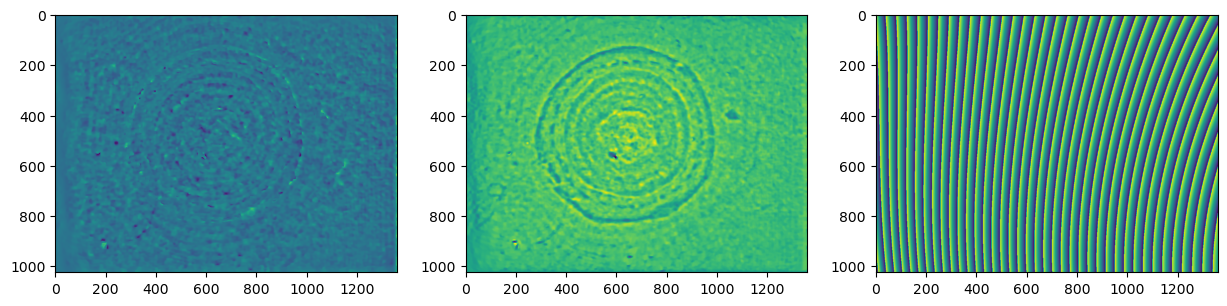

251 0.06564205003328767
252 0.06561359346753365
253 0.06555218664576778
254 0.06551906948432679
255 0.0654903361649924
256 0.06544073933062622
257 0.0654257004480619
258 0.06538119004646135
259 0.0653442468665371
260 0.06530916090859687
261 0.06527211477287019
262 0.06524047662648264
263 0.06520267381310177
264 0.06517161758594997
265 0.06515011638796359
266 0.06510277776274576
267 0.06506914164260219
268 0.06503071497959603
269 0.06500151768406273
270 0.06497717332260185
271 0.06493911385075912
272 0.06491288392203941
273 0.06486111011957167
274 0.06485256293764194
275 0.06478554109485676
276 0.0647839523195885
277 0.06470942959218284
278 0.06469298309674748
279 0.06464938716404428
280 0.06462245041664741
281 0.06458865490353087
282 0.06455921982148372
283 0.06452285395193133
284 0.06449879408182144
285 0.0644545401973945
286 0.0644381662210125
287 0.06438591210607289
288 0.06437242053224168
289 0.06432497712653162
290 0.06429171754232087
291 0.06424279826929932
292 0.0642087434050822

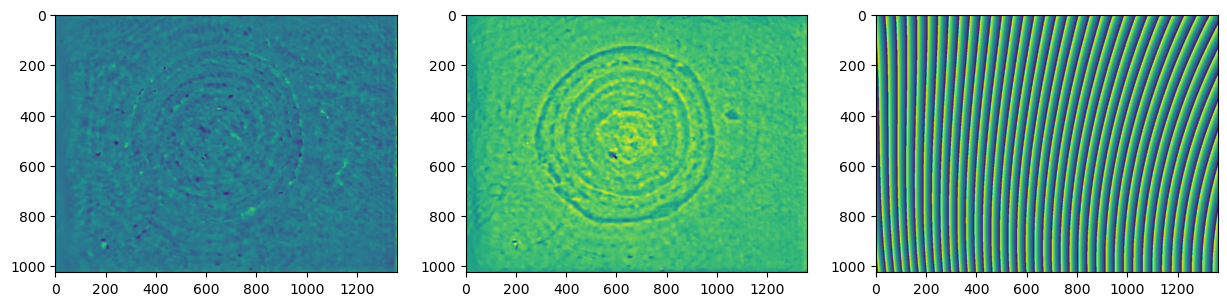

301 0.06391380152679331
302 0.06389617444120574
303 0.06386073284697455
304 0.06382560589811791
305 0.06382780463669965
306 0.06376255119084936
307 0.06375841242677538
308 0.06370470869356021
309 0.06369401159026937
310 0.06368319449534798
311 0.06367162443311769
312 0.0636537473247327
313 0.06360060016296545
314 0.06357284343429326
315 0.06351598375730341
316 0.06351267529969404
317 0.06345837898608231
318 0.06343607127381817
319 0.06338616788484638
320 0.063379833778478
321 0.06331612718053078
322 0.06332284459864736
323 0.06326365304120814
324 0.06325649814217787
325 0.06321352458257504
326 0.0631922046876724
327 0.06314963480260626
328 0.0631417664908629
329 0.06308605816363004
330 0.06309359337767184
331 0.06301241462849634
332 0.06302153055951307
333 0.06296948668505457
334 0.06297045945021872
335 0.06291405585442572
336 0.06290525890543533
337 0.06286379777961425
338 0.06284826115410617
339 0.06279858878828859
340 0.06279133370313655
341 0.06274567971081832
342 0.062750443538936

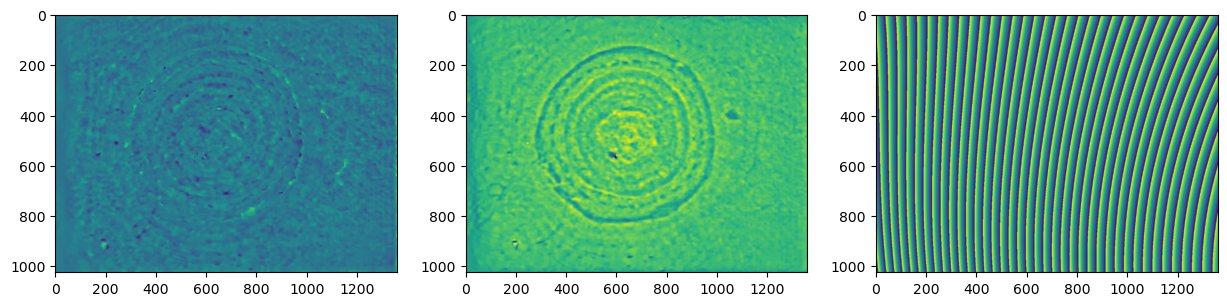

351 0.062454002562507195
352 0.06243880586623051
353 0.06238886114779501
354 0.06239893665621332
355 0.062333902220780654
356 0.06235278149629594
357 0.06228763374572563
358 0.062306990635527484
359 0.06223370285971404
360 0.06224295233390838
361 0.062187200411529434
362 0.06217724981163819
363 0.06213065931647974
364 0.06213287510192539
365 0.06209680915262951
366 0.06207232550472038
367 0.06203121065610465
368 0.062008583536511855
369 0.06201242951728366
370 0.061962049468925216
371 0.0619399733466036
372 0.06195017237476584
373 0.061885924812206186
374 0.06188843711511606
375 0.061836360919645623
376 0.06182454573876744
377 0.06177999458111474
378 0.0617589820147222
379 0.061740264157798055
380 0.0617106297501407
381 0.06168439294374778
382 0.06167502263443696
383 0.06160773413395902
384 0.0616148296559437
385 0.06157832909177569
386 0.06157919936583549
387 0.06152653689565638
388 0.06150723108507641
389 0.06149588727949171
390 0.06145469347663657
391 0.06143851567777155
392 0.06140

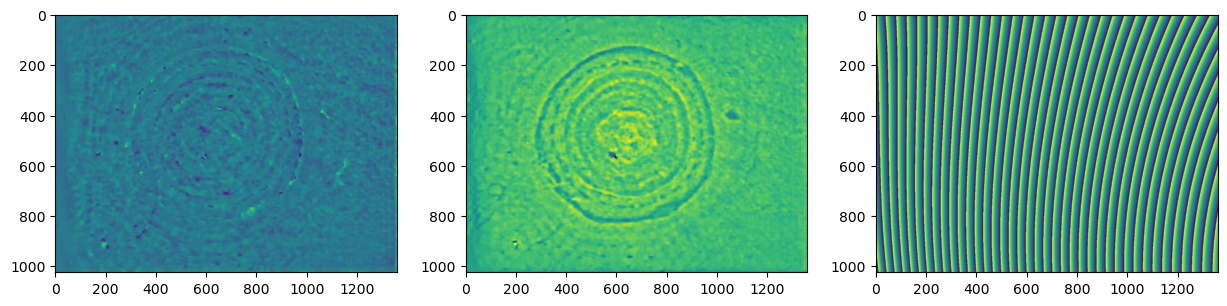

401 0.0612053480636288
402 0.06118981813187982
403 0.06114792855281122
404 0.061141650554830194
405 0.061104973441224925
406 0.06111081886106072
407 0.06106928776711024
408 0.061045069038519736
409 0.06101252839923417
410 0.06100367020551638
411 0.060935808703855066
412 0.060949815348928585
413 0.060904459432981534
414 0.060907171803832774
415 0.060893742264328546
416 0.0608491456178897
417 0.06083666800854723
418 0.060820332116928416
419 0.060791879156138706
420 0.0607603072179668
421 0.06074325585366944
422 0.06072358614892144
423 0.060702750712915456
424 0.06067696997393691
425 0.06064689617207416
426 0.06062406147990365
427 0.06063765921821387
428 0.060595455560693234
429 0.06059644407645182
430 0.06055532928881685
431 0.06056054540199624
432 0.06049404026082314
433 0.060508738311755336
434 0.06046380272677611
435 0.06045258168236141
436 0.06043100773635205
437 0.06041216245673872
438 0.06038435367170598
439 0.06036408070414255
440 0.060321861134223165
441 0.06032271904292823
442 0

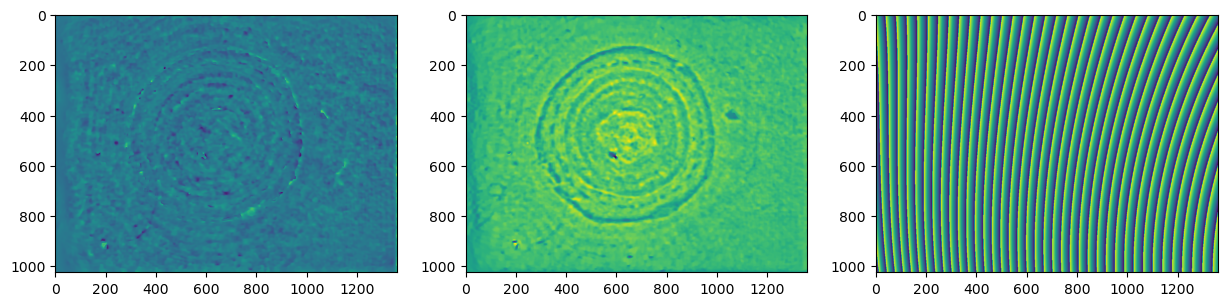

451 0.06012805108611119
452 0.06009413037703196
453 0.06010044626800698
454 0.06007027454783359
455 0.06004292583715873
456 0.06003757587569661
457 0.06000786555828581
458 0.05999079988465523
459 0.05997122525263057
460 0.059967922712429636
461 0.05992733430128333
462 0.059921863752189164
463 0.05989464890766204
464 0.059863655719597154
465 0.059833787467487826
466 0.05980007519597045
467 0.05979671841080662
468 0.059792973435944696
469 0.059811763654661655
470 0.059786459720147705
471 0.059772113664152346
472 0.05972873402309642
473 0.059713518375343826
474 0.05967525910985238
475 0.05967559673399127
476 0.05965830848599924
477 0.059616934890644624
478 0.05961540508546555
479 0.059571409672757314
480 0.05957149611793582
481 0.059547088379750535
482 0.05955064641809682
483 0.059511596637419575
484 0.05951088685006528
485 0.0594548217388698
486 0.059472046466272285
487 0.0594232024700429
488 0.059416665301870696
489 0.05938249513862329
490 0.059386200134831243
491 0.05935547147299661
49

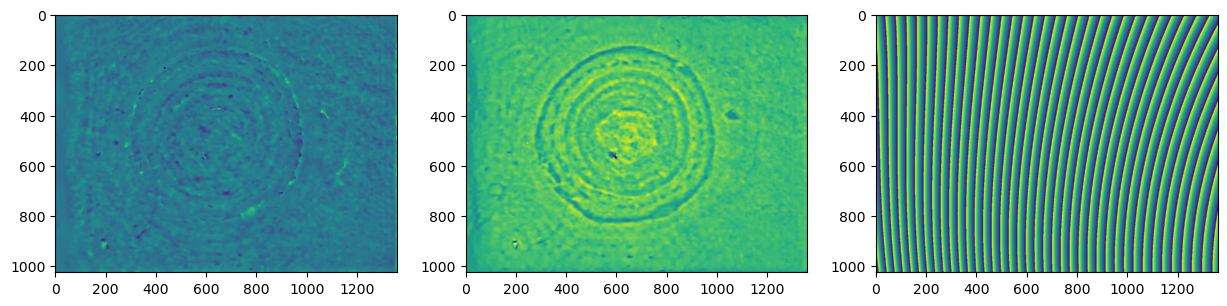

In [13]:
epochs = 501
loss_arr = []


for itr in range(epochs):

    optimizer.zero_grad()
    # optimizer_proc.zero_grad()

    obj = obj_amp*torch.exp(1j*obj_phase)
    
    wave_phase = ((A)@coeffs).reshape(1024, 1360)
    wave = torch.exp(1j*wave_phase)
    
    wave_op = wave*obj

    wave_obj.wavefield(wave_op.T)
    dist = torch.tensor(155.003) # mm
    wave_at_img = wave_obj.propogate(dist)
    wave_z = torch.angle(wave_at_img)
    wave_z += cons
    loss_phase = loss_fn(wave_z, target_phase)
    loss_amp = loss_fn(torch.abs(wave_at_img), target_abs)

    loss = 0.5*(loss_amp + loss_phase) + total_variation_loss(obj_amp, 0.1) + total_variation_loss(obj_phase, 0.1)

    # proc = model(obj_phase.unsqueeze(0).unsqueeze(0)).squeeze()
    # loss_proc = 0.9*l2_loss(proc, obj_phase) + total_variation_loss(proc, 0.1)

    loss.backward()
    # loss_proc.backward()
    
    optimizer.step()
    # optimizer_proc.step()

    loss_arr.append(loss.item())
    print(itr, loss_arr[-1])

    if (itr) % 50 == 0:

        fig, axs = plt.subplots(1, 3, figsize=(15, 8))

        axs[0].imshow(obj_phase.detach())
        # axs[1].imshow(proc.detach())
        axs[1].imshow(obj_amp.detach())
        axs[2].imshow(torch.angle(wave.detach()))

        plt.show()

In [14]:
dist, cons.grad

(tensor(155.0030), tensor(0.))

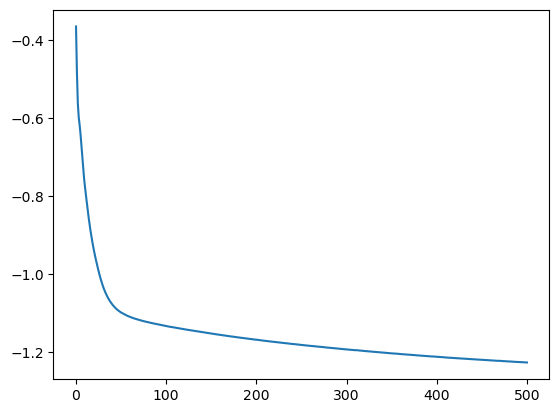

In [17]:
plt.plot(np.log10(loss_arr))

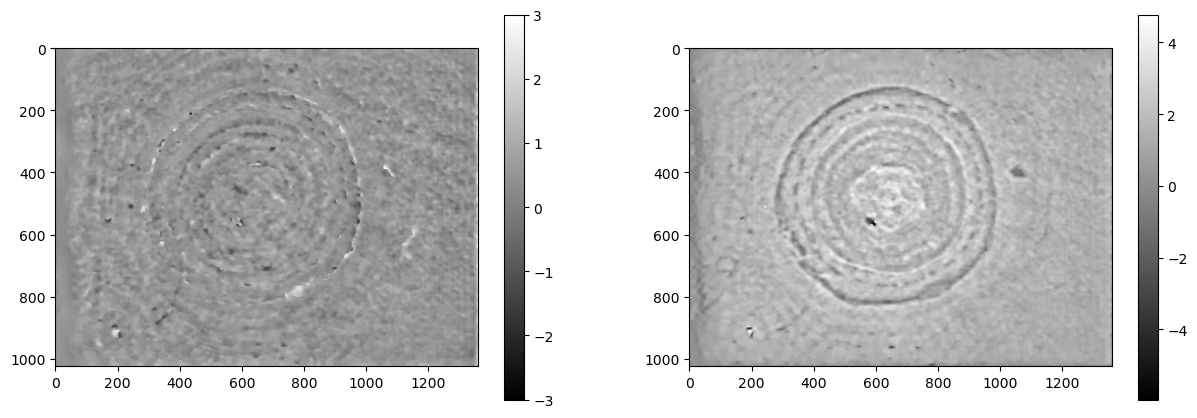

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cm1 = axs[1].imshow(obj_amp.detach(), cmap='gray')
cm0 = axs[0].imshow(obj_phase.detach(), vmin=-3, vmax=3, cmap='gray')

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

# axs[0].grid()
# axs[1].grid()

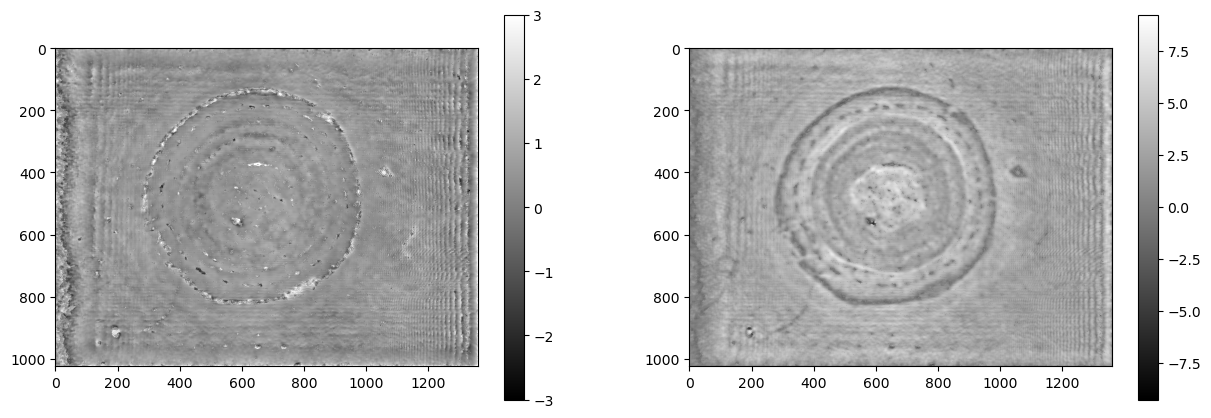

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cm1 = axs[1].imshow(obj_amp.detach(), cmap='gray')
cm0 = axs[0].imshow(obj_phase.detach(), vmin=-3, vmax=3, cmap='gray')

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

# axs[0].grid()
# axs[1].grid()

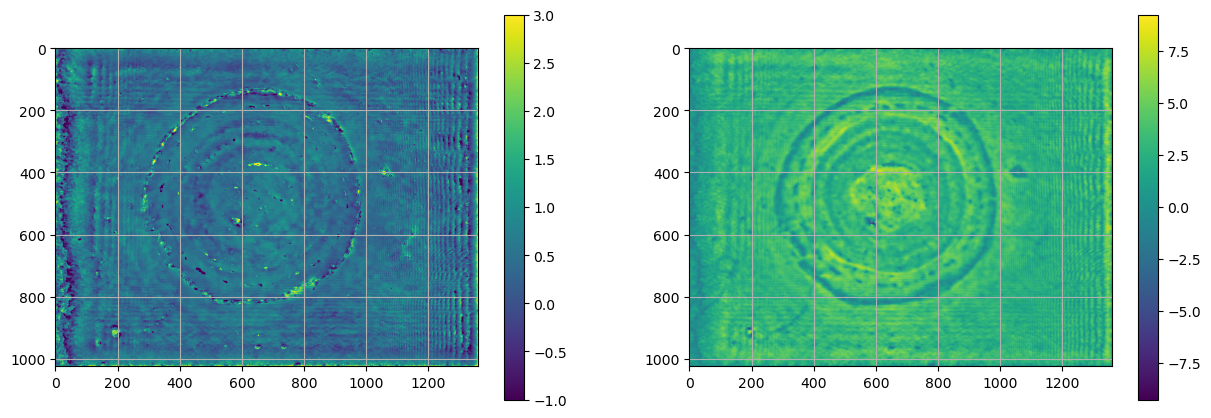

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cm1 = axs[1].imshow(obj_amp.detach())
cm0 = axs[0].imshow(obj_phase.detach(), vmin=-1, vmax=3)

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

axs[0].grid()
axs[1].grid()

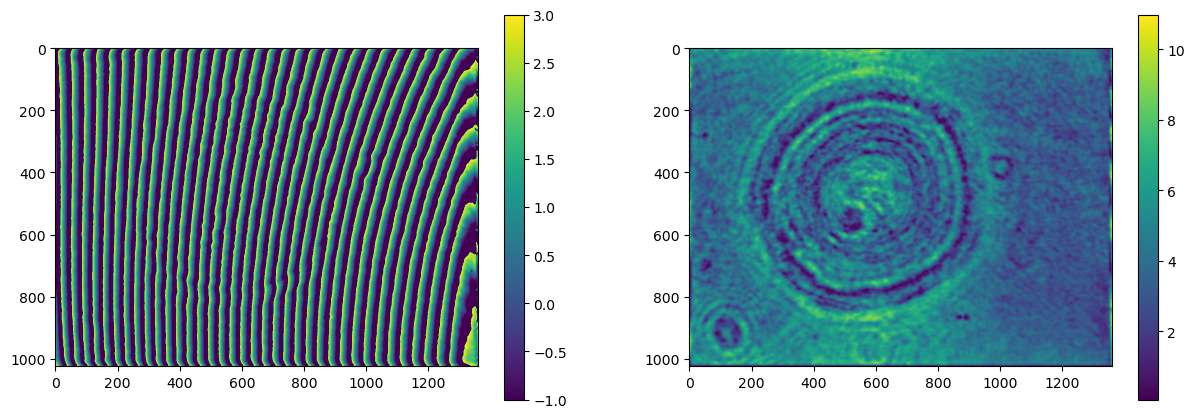

In [178]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cm1 = axs[1].imshow(torch.abs(wave_at_img).T.detach())
cm0 = axs[0].imshow(torch.angle(wave_at_img).T.detach(), vmin=-1, vmax=3)

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

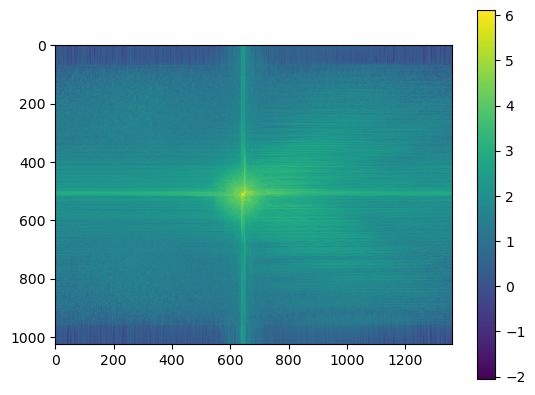

In [172]:
plt.imshow(np.log10(torch.abs(torch.fft.fftshift(torch.fft.fft2(wave_at_img.detach())))).T)
plt.colorbar()

tensor([[ -12.7241],
        [-114.5435],
        [ -12.9551],
        [   4.7421],
        [   6.8633],
        [-118.1326],
        [   2.3889],
        [   2.4276],
        [   1.5576],
        [   3.9442]], requires_grad=True)

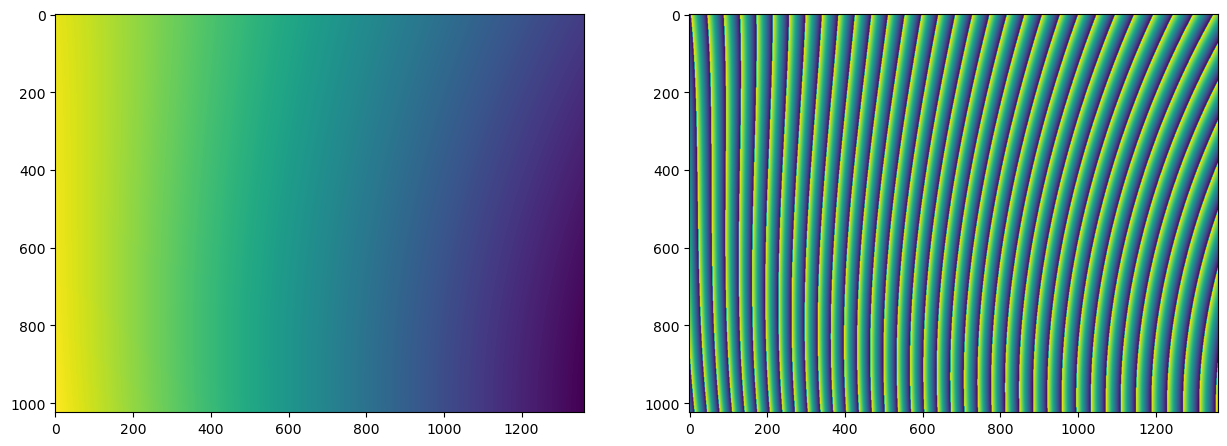

In [173]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[1].imshow(torch.angle(wave).detach())
axs[0].imshow(wave_phase.detach())

coeffs

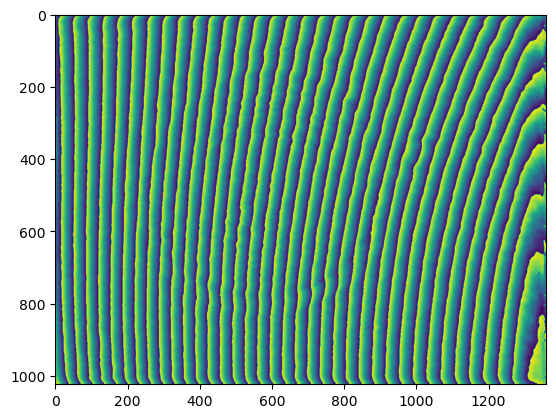

In [174]:
plt.imshow(wave_z.detach().T)

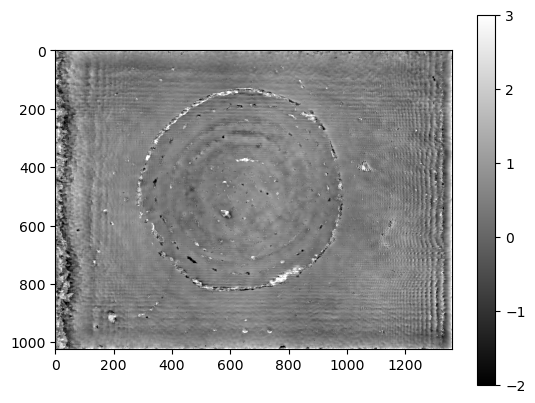

In [175]:
plt.imshow((obj_phase.detach().numpy()), cmap='gray', vmin=-2, vmax=3)
plt.colorbar()